# Autoencoder and Variational Autoencoder

本單元，我們將介紹並帶各位同學實作非監督式學習中的自編碼器及其變形。

## 1. 初始準備

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ipywidgets import interact, FloatSlider

In [6]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda
from keras.layers import Dense #DNN
from keras.layers import Conv2D, MaxPooling2D #CNN
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

## 2. 讀入 MNIST 數據庫
老規矩，開場就先召喚我們的好朋友 - MNIST 手寫數字數據庫

In [7]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

調整資料長相及單位化

In [8]:
x_train = x_train0.reshape(60000, -1) # -1 是自己調成正確值
x_test = x_test0.reshape(10000, -1)

x_train = x_train/255
x_test = x_test/255

# 3. Autoencoder

Autoencoder，又稱為自編碼器，是一個將資料壓縮再還原的模型，通常由一編碼器及一解碼器所組成。

給定一組數據集 $\mathcal{D}\subseteq\mathbb{R}^n$ 以及一個壓縮維度 $m$，其中 $m < n$。

數學上來說表示，Autoencoder 由 $\operatorname{Enc}:\mathbb{R}^n\to\mathbb{R}^m$ 和 $\operatorname{Dec}:\mathbb{R}^m\to\mathbb{R}^n$ 所構成：

$$ \mathbb{R}^n \overset{\operatorname{Enc}}{\to} \mathbb{R}^m \overset{\operatorname{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\operatorname{Enc}}{\mapsto} h \overset{\operatorname{Dec}}{\mapsto} \hat{x} $$

且對於任意的 $x\in\mathcal{D}$，我們希望 $x\approx\hat{x} = \operatorname{Dec}(h) = \operatorname{Dec}\big(\operatorname{Enc}(x)\big)$

其中，$h = \mbox{Enc}(x)$ 稱之 $x$ 為潛在表示法 (latent representation)，而 $\hat{x}$ 則是 $x$ 自編碼過後的還原資料。

換言之，我們希望原本的資料 $x$，經過函數 $\mbox{Enc}$ 編碼成維度比較小的資料 $h$，再透過函數 $\mbox{Dec}$ 還原成 $\hat{x}$。

一般而言，我們會希望 $\mbox{Enc}$ 和 $\mbox{Dec}$  看起來有點對稱。

**為了視覺化的目的，經常會考慮 $m=2$ 的狀況。**

## 3.1 Autoencoder 與手寫辨識資料 MNIST

我們考慮具有下列結構的 Autoencoder:

<img src="autoencoder.png" alt="drawing" style="width: 600px;"/>


為了方便，我們將三個變數的符號表示出來：

$$ x \overset{\mbox{Enc}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$

In [9]:
enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [10]:
x = Input(shape=(784,))

h = enc_2(enc_1(x))

x_hat = dec_1(dec_2(h))

autoencoder = Model(x, x_hat)

In [11]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


一樣的，當模型 compile 之後，便可以進行資料的訓練、預測等等，請有興趣的同學讀入 MNIST 手寫辨識之料後，自行完成這個模型的訓練。

In [12]:
autoencoder.compile(loss='mse', optimizer=Adam(lr=1e-4))

In [13]:
autoencoder.fit(x_train, x_train, batch_size=1024, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 1s 13us/step - loss: 0.2097
Epoch 2/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.1670
Epoch 3/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.1364
Epoch 4/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.1157
Epoch 5/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.1020
Epoch 6/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.0928
Epoch 7/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.0866
Epoch 8/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.0822
Epoch 9/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.0791
Epoch 10/10
60000/60000 [==============================] - 0s 5us/step - loss: 0.0769


如果覺得訓練太久的話，也可以使用我們準備好的權重。

In [14]:
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

## 3.2 視覺化 - 子模型的取出
為了視覺化(及其他潛在應用)，我們也會從 Autoencoder 將 Encoder 和 Decoder 分別定義出來。

In [15]:
Encoder = Model(x, h)

In [16]:
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 不可以 Decoder = Model(h, x_hat) (Why?)

Decoder 是由 $h$ 開始，因此，我們先準備一個與 $h$ 相同大小的 `Input`，並餵進 `dec_2` 及 `dec_1` 中即可。

In [81]:
h_input = Input(shape=(2,))

Decoder = Model(h_input, dec_1(dec_2(h_input)))

In [21]:
Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## 3.3 視覺化 - Encoder

首先，我們隨便抽取一張圖，並透過 Encoder 來算出它的 latent 表示。

In [26]:
idx = 5998
Encoder.predict(x_train[idx:idx+1])

array([[0.24474536, 0.11025778]], dtype=float32)

接者，我們從 $10000$ 筆測試資料隨機挑選 $3000$ 手寫辨識資料，將其轉換成 latent 表示法，並畫在同一平面上。

In [27]:
indices = np.random.randint(10000, size=3000)

In [28]:
latent = Encoder.predict(x_test[indices])

In [29]:
latent.shape

(3000, 2)

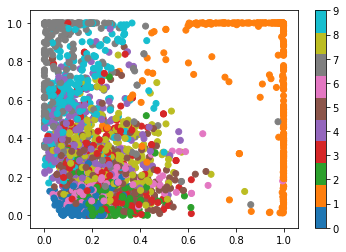

In [30]:
plt.scatter(latent[:, 0], latent[:, 1], c=y_test0[indices], cmap='tab10')
plt.colorbar()

這是好的 encoder 的方法嗎? 為什麼?

### 2.4 視覺化 - Decoder

首先，我們在 $[0, 1]\times[0, 1]$ 這個單位正方形內均勻取樣 $15*15$ 個點，並將這 $225$ 個平面上的點，透過 Decoder 進行圖片的還原。

In [31]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [32]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

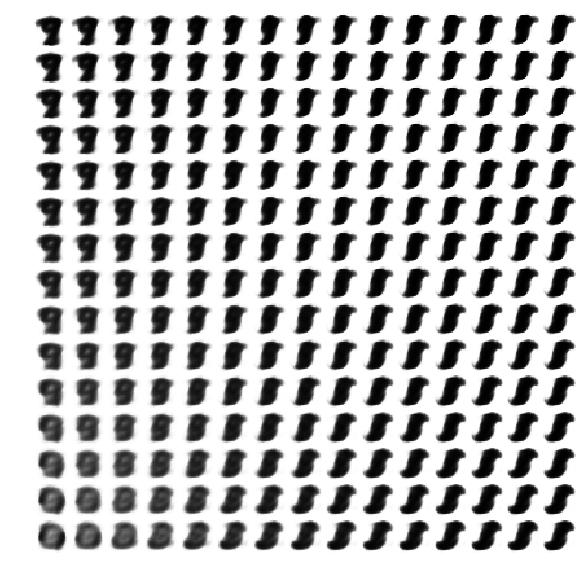

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

# 4.Variational Autoencoder
若每筆資料的 latent 不僅僅是一個**位置**，而是一個分布，且分布的平均值附近都能還原，那我們應該怎麼做呢？

在此，我們將介紹 Variational Autoencder，一種當代知名的自編碼器，就具有上述的效果。

此時 $\mbox{Enc}$ 和 $\mbox{Dec}$ 並不直接串接，而是會透過一常態抽樣的函數以下面的形式串接。

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m\times\mathbb{R}^m \overset{\mbox{Sampling}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$


我們準備建構的 Variational Autoencoder 的結構如下：

<img src="variational_autoencoder.png" alt="drawing" style="width: 800px;"/>

在此， Encoder 的作用不是將資料表示成 latent，而是將資料表示成常態分配的兩個參數，平均數與變異數。

而 Decoder 也不再直接使用 Encoder 的結果，而是將 Encoder 的結果作為常態抽樣的兩個參數來進行。

因此，資料經過 Encoder，會得到一適當大小的常態分配之參數，而 Decoder 則使用這組參數進行抽樣。

即使是同一筆資料，Decoder 每次接受到的 latent 表示法可能都不一樣 (但會在某個平均數附近)。

要注意到的是，由於變異數恆正的特性，我們可以下面是以學習取對數後的變異數 (log-variance)。

## 4.1 VAE 的建立
為了避免混淆，我們重新定義所有變數，首先，我們定義 Encoder 上的三個神經網路層

In [34]:
enc_1 = Dense(100, activation='sigmoid')
enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [35]:
x = Input(shape=(784, ))
enc_x = enc_1(x)

z_mean=enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

定義抽樣函數並透過 ``Lambda`` 將其轉換成 Keras layer。

透過 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$，我們透過以下方式定義抽樣函數。

In [39]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [40]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [41]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [42]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_3 (

## 4.2 Loss 函數的建立
VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，因此，我們在此直接建立訓練 VAE 時的 loss 函數。

若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

同學有興趣可以證明下面關於 KL 散度在兩個常態分配上的性質：若 $p\sim N(\mu_1,\sigma_1^2)$, $q\sim N(\mu_2,\sigma_2^2)$，則 $KL(p, q) = \log\dfrac{\sigma_2}{\sigma_1} + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\dfrac{1}{2}$

In [44]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

## 4.3 訓練 VAE

In [45]:
VAE.compile(loss=vae_loss, optimizer=Adam(lr=1e-4))

In [46]:
VAE.fit(x_train, x_train, batch_size=1024, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 1s 10us/step - loss: 507.6623
Epoch 2/10
60000/60000 [==============================] - 0s 6us/step - loss: 439.2103
Epoch 3/10
60000/60000 [==============================] - 0s 6us/step - loss: 387.1914
Epoch 4/10
60000/60000 [==============================] - 0s 6us/step - loss: 347.8694
Epoch 5/10
60000/60000 [==============================] - 0s 6us/step - loss: 318.0418
Epoch 6/10
60000/60000 [==============================] - 0s 6us/step - loss: 294.6919
Epoch 7/10
60000/60000 [==============================] - 0s 6us/step - loss: 277.3304
Epoch 8/10
60000/60000 [==============================] - 0s 6us/step - loss: 263.2251
Epoch 9/10
60000/60000 [==============================] - 0s 6us/step - loss: 254.3248
Epoch 10/10
60000/60000 [==============================] - 0s 6us/step - loss: 246.1545


### Weights 讀進來

In [70]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

## 4.4 VAE 的視覺化呈現
與視覺化 Autoencoder 時的方式一樣，我們先分別定義出 Encoder 和 Decoder。

$$\mbox{VAE:}~x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$
$$\mbox{Encoder:}~x \overset{\mbox{Enc}}{\mapsto} \mu$$
$$\mbox{Decoder:}~h \overset{\mbox{Dec}}{\mapsto} \hat{x}$$

In [71]:
VAE_encoder = Model(x, z_mean)

In [72]:
VAE_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [82]:
VAE_decoder = Model(h_input, dec_1(dec_2(h_input)))

In [83]:
VAE_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


首先，我們進行 Encoder 的視覺化呈現。

In [75]:
VAE_latent = VAE_encoder.predict(x_test[indices])

In [76]:
VAE_latent.shape

(3000, 2)

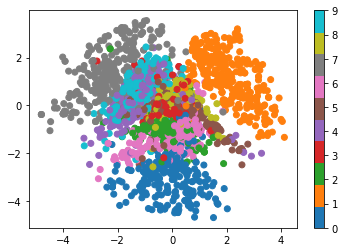

In [77]:
plt.scatter(VAE_latent[:, 0], VAE_latent[:, 1], c=y_test0[indices], cmap='tab10')
plt.colorbar()

In [78]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

接著，我們進行 Decoder 的視覺化呈現。

In [84]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

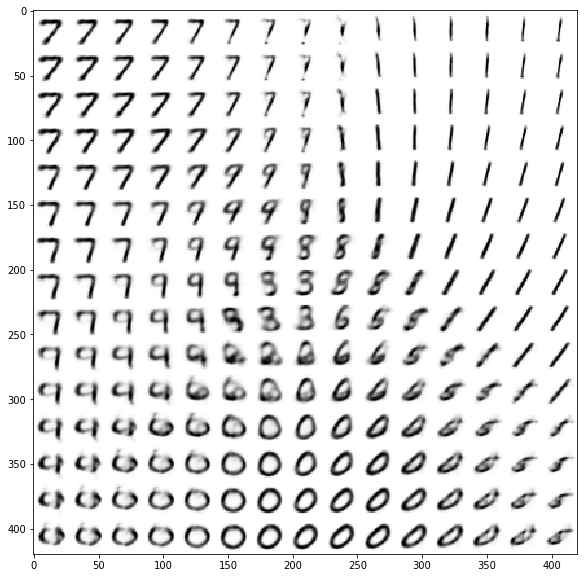

In [86]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.show()

## 4.5 與 Autoencoder 的 Encoder 進行視覺化比較

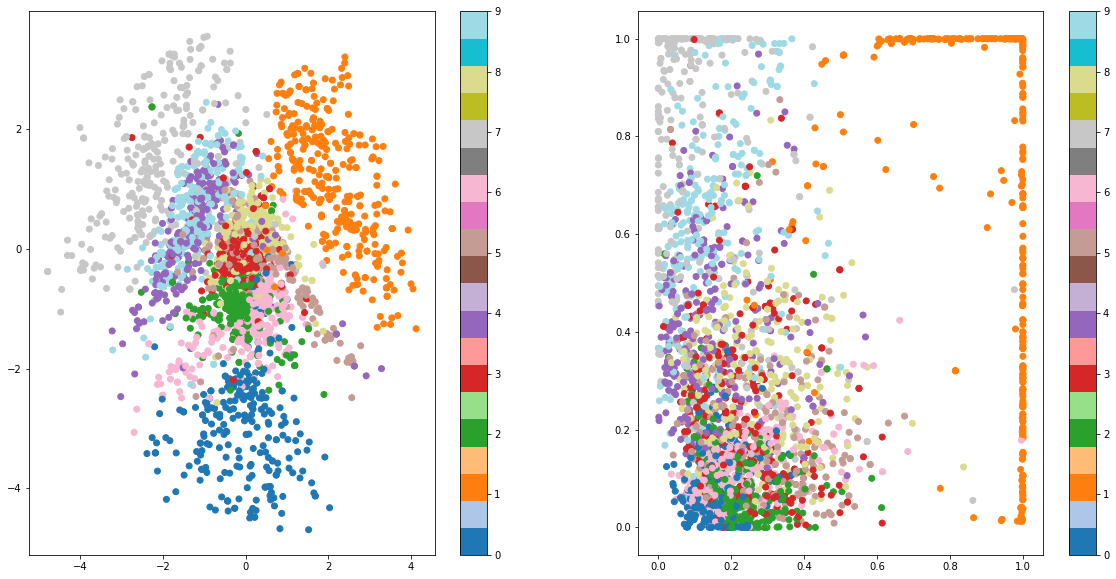

In [89]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latent[:, 0], VAE_latent[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latent[:, 0], latent[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

## 4.6 動態比較

In [93]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [94]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)

In [95]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>